In [ ]:
# Для набора данных blood_cells.
# ( вариант 1 использовать ссгенерированные данные)
# ( вариант 2 использовать оригинальные данные)
# ( вариант 3 использовать поднабор данных из 10-50 изображений)
##################
# Решите задачу сегментации  и подсчет количества клеток.
# Алгоритм 1. Метод Хафа для поиска окружностей.
# Алгоритм 2. Алгоритм водораздел+карта расстояний для сегментации пересекающихся объектов.
##################
# Показатели качества решения задачи сегментации: accuracy, precision. Усреднить по количеству изображений теста.
# min количество изобаржений для тестирования - 10.

#Для создания пользовательского датасета class должен переопределить следующие методы:
#def init(self, param1, param2, param3...): вызывается один раз при создании объекта класса-наследника Dataset object.
#Сохраняются директории-пути к файлам и аннотациям, методы аугмпентации пользовательских данных.
#def len(self): Возвращаеет Количество экземпляров выборки в пользовательском датасете
#def getitem(self, idx): Загружает и возвращает экзмляр данных по индексу idx

Изображение 1:
  Метод Хафа: Найдено клеток = 193
  Алгоритм водораздела: Найдено клеток = 28


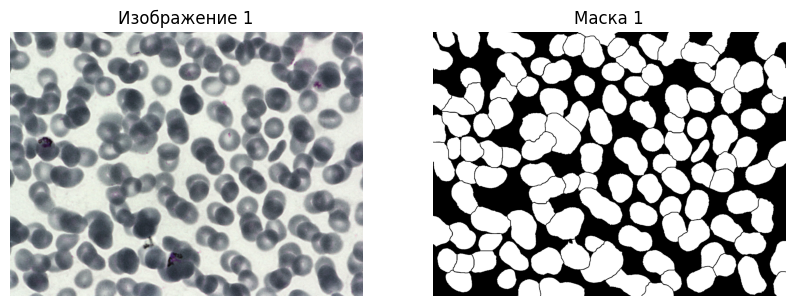

Изображение 2:
  Метод Хафа: Найдено клеток = 19
  Алгоритм водораздела: Найдено клеток = 10


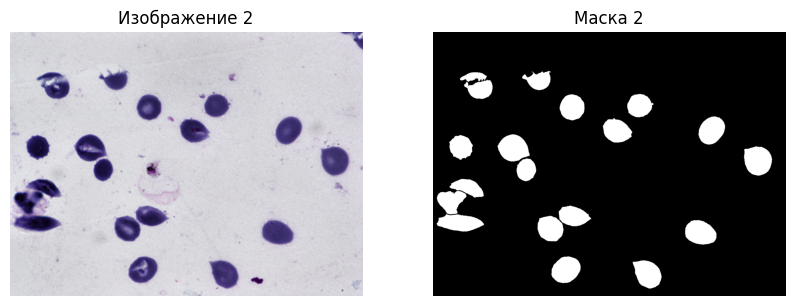

Изображение 3:
  Метод Хафа: Найдено клеток = 279
  Алгоритм водораздела: Найдено клеток = 32


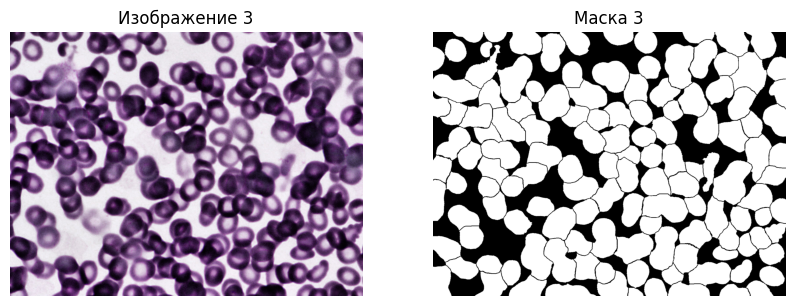

Изображение 4:
  Метод Хафа: Найдено клеток = 7
  Алгоритм водораздела: Найдено клеток = 20


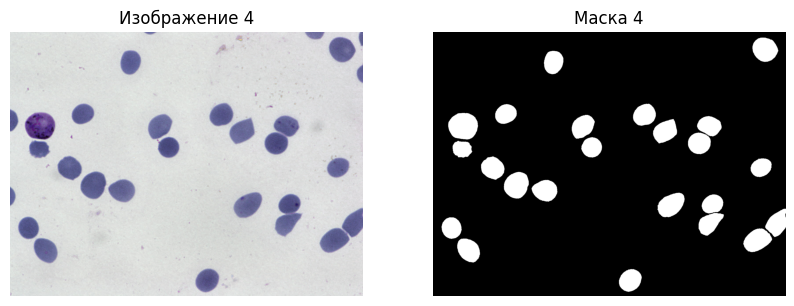

Изображение 5:
  Метод Хафа: Найдено клеток = 127
  Алгоритм водораздела: Найдено клеток = 7


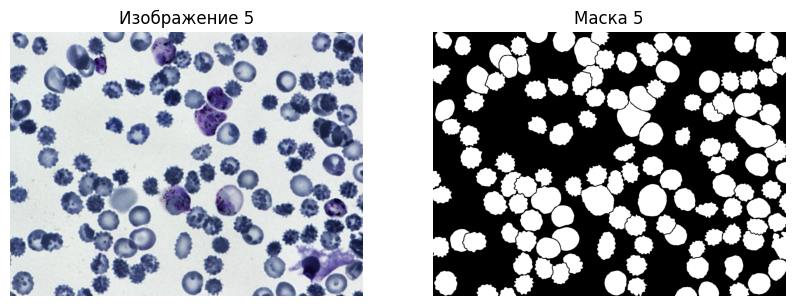

Изображение 6:
  Метод Хафа: Найдено клеток = 130
  Алгоритм водораздела: Найдено клеток = 28


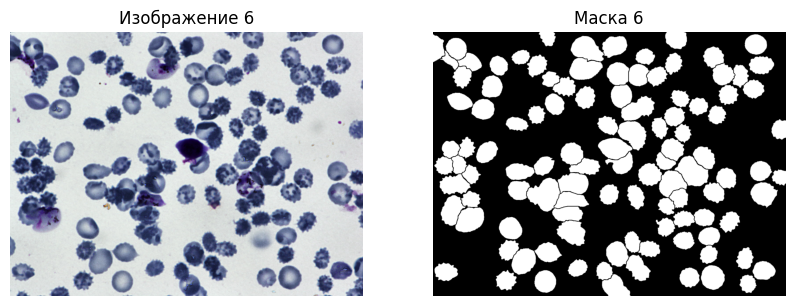

Изображение 7:
  Метод Хафа: Найдено клеток = 126
  Алгоритм водораздела: Найдено клеток = 51


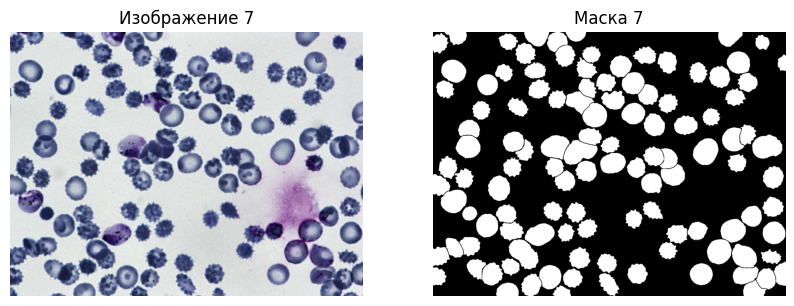

Изображение 8:
  Метод Хафа: Найдено клеток = 48
  Алгоритм водораздела: Найдено клеток = 24


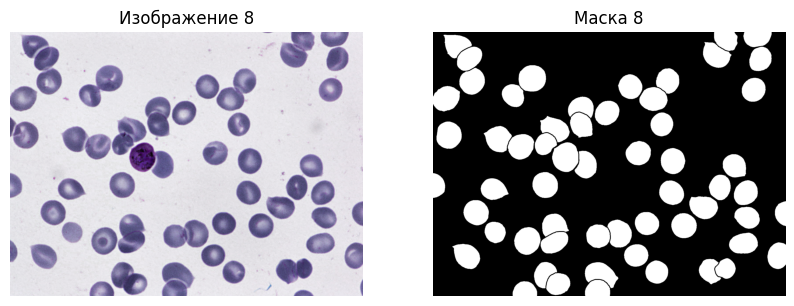

Изображение 9:
  Метод Хафа: Найдено клеток = 107
  Алгоритм водораздела: Найдено клеток = 27


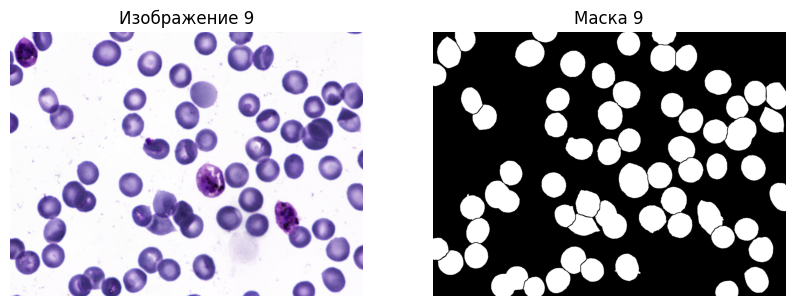

Изображение 10:
  Метод Хафа: Найдено клеток = 70
  Алгоритм водораздела: Найдено клеток = 55


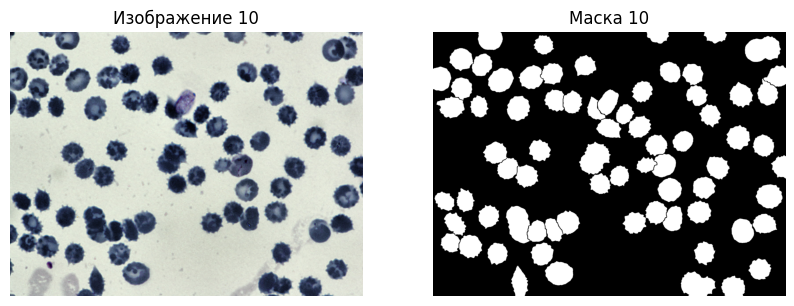


Итоговые результаты:
Метод Хафа: Средняя accuracy = 0.64, Средняя precision = 0.40
Алгоритм водораздела: Средняя accuracy = 0.64, Средняя precision = 0.46
Общее количество клеток (метод Хафа): 1106
Общее количество клеток (алгоритм водораздела): 282


In [ ]:
#использовался поднабор данных из 42 изображений
import os
import cv2
import numpy as np
from skimage import measure
from sklearn.metrics import accuracy_score, precision_score
from scipy import ndimage
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

class BloodCellsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Метод Хафа для поиска окружностей
def hough_circle_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    # Поиск окружностей
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
        param1=50, param2=30, minRadius=10, maxRadius=50
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        return len(circles[0])
    return 0

# Алгоритм водораздела с картой расстояний
def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    # Бинаризация изображения
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Удаление шума
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Карта расстояний
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Маркировка меток
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0

    # Применение алгоритма водораздела
    markers = cv2.watershed(image, markers)

    # Подсчет количества клеток
    unique_markers = np.unique(markers)
    return len(unique_markers) - 2

# Оценка качества сегментации
def evaluate_segmentation(mask, predicted_mask):

    mask = (mask > 0).astype(np.uint8)
    predicted_mask = (predicted_mask > 0).astype(np.uint8)

    accuracy = accuracy_score(mask.flatten(), predicted_mask.flatten())
    precision = precision_score(mask.flatten(), predicted_mask.flatten())

    return accuracy, precision

if __name__ == "__main__":

    image_dir = "/content/original_train11"
    mask_dir = "/content/mask_train1"

    dataset = BloodCellsDataset(image_dir, mask_dir)

    # Тестирование на 10 изображениях
    accuracies_hough = []
    precisions_hough = []
    accuracies_watershed = []
    precisions_watershed = []

    total_hough_cells = 0  # Общее количество клеток, найденных методом Хафа
    total_watershed_cells = 0  # Общее количество клеток, найденных алгоритмом водораздела

    for i in range(min(10, len(dataset))):
        image, mask = dataset[i]

        # Метод Хафа
        hough_count = hough_circle_detection(image)
        total_hough_cells += hough_count
        hough_mask = np.zeros_like(mask)
        cv2.circle(hough_mask, (100, 100), hough_count, 255, -1)
        acc_hough, prec_hough = evaluate_segmentation(mask, hough_mask)
        accuracies_hough.append(acc_hough)
        precisions_hough.append(prec_hough)

        # Алгоритм водораздела
        watershed_count = watershed_segmentation(image)
        total_watershed_cells += watershed_count
        watershed_mask = np.zeros_like(mask)
        cv2.circle(watershed_mask, (100, 100), watershed_count, 255, -1)
        acc_watershed, prec_watershed = evaluate_segmentation(mask, watershed_mask)
        accuracies_watershed.append(acc_watershed)
        precisions_watershed.append(prec_watershed)

        print(f"Изображение {i + 1}:")
        print(f"  Метод Хафа: Найдено клеток = {hough_count}")
        print(f"  Алгоритм водораздела: Найдено клеток = {watershed_count}")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Изображение {i + 1}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Маска {i + 1}")
        plt.axis('off')
        plt.show()

    # Усреднение метрик
    avg_accuracy_hough = np.mean(accuracies_hough)
    avg_precision_hough = np.mean(precisions_hough)
    avg_accuracy_watershed = np.mean(accuracies_watershed)
    avg_precision_watershed = np.mean(precisions_watershed)

    print("\nИтоговые результаты:")
    print(f"Метод Хафа: Средняя accuracy = {avg_accuracy_hough:.2f}, Средняя precision = {avg_precision_hough:.2f}")
    print(f"Алгоритм водораздела: Средняя accuracy = {avg_accuracy_watershed:.2f}, Средняя precision = {avg_precision_watershed:.2f}")
    print(f"Общее количество клеток (метод Хафа): {total_hough_cells}")
    print(f"Общее количество клеток (алгоритм водораздела): {total_watershed_cells}")

In [ ]:
!unzip /content/drive/MyDrive/folder/mask_train1.zip

Archive:  /content/drive/MyDrive/folder/mask_train1.zip
   creating: mask_train1/
  inflating: mask_train1/592c941a-aa54-4971-b499-dc47356f80a3.png  
  inflating: mask_train1/5939f341-a886-4f63-ae87-2219d000a1d4.png  
  inflating: mask_train1/597bbff8-6592-41cf-8946-e59b0d1f289a.png  
  inflating: mask_train1/59daa25e-85d6-42f2-8f39-cc9f9d5d252e.png  
  inflating: mask_train1/59dc7da9-35d1-421e-a61b-1e9637bfbfa1.png  
  inflating: mask_train1/59f5699f-885f-4004-b783-a60060144e43.png  
  inflating: mask_train1/5a539312-6cfa-43e6-8d5d-db883f343ad9.png  
  inflating: mask_train1/5a631871-2fc7-4a68-9c39-f3b9a0bf4a04.png  
  inflating: mask_train1/5bf91ff9-80df-49c0-9c3e-599357d95530.png  
  inflating: mask_train1/5bfde411-aa51-45d0-8b67-a57c5f1e628b.png  
  inflating: mask_train1/5c037ffc-f515-48b3-b231-c110fbd2b8ca.png  
  inflating: mask_train1/5c399ab9-492c-4bfc-a452-83aba574a3bc.png  
  inflating: mask_train1/5c5b7965-1a44-44b8-aa43-660823e61821.png  
  inflating: mask_train1/5c68070c-